## EJERCICIO 2


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

2023-08-22 18:32:11.991534: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [227]:
def limpiar_y_convertir_a_float(valor_str):
    return float(valor_str.replace(',', ''))

In [3]:
consumo = pd.read_csv('./consumo/Consumo.csv')
for column in consumo.columns:
    if column == 'Fecha':
       consumo['Fecha'] = consumo['Fecha'].replace({'ene-': 'Jan-','feb-': 'Feb-','mar-': 'Mar-','abr-': 'Apr-','may-': 'May-','jun-': 'Jun-','jul-': 'Jul-','ago-': 'Aug-','sep-': 'Sep-','oct-': 'Oct-','nov-': 'Nov-','dic-': 'Dec-'}, regex=True)
       consumo['Fecha'] = pd.to_datetime(consumo['Fecha'], format='%b-%y')
    else:
        if consumo[column].dtype == 'object':
            consumo[column] = consumo[column].apply(limpiar_y_convertir_a_float)


consumo["Diesel_conjunto"] = consumo["Diesel alto azufre"] + consumo["Diesel bajo azufre"]
consumo["Diesel_conjunto"] = consumo["Diesel_conjunto"].fillna(0)
consumo["Diesel_conjunto"] = consumo["Diesel_conjunto"].astype(float)
consumo.dropna(subset=["Diesel_conjunto"], inplace=True)
nans_por_columna = consumo.isna().sum()
consumo_copy = consumo.copy()
consumo.set_index('Fecha', inplace=True)


In [4]:
numerics= ["Gasolina regular", "Gasolina superior", "Diesel_conjunto", "Gas licuado de petróleo"]
consumo_numerics = consumo[numerics]


In [5]:
consumo_copy.head()

,Fecha,Aceites lubricantes,Asfalto,Bunker,Ceras,Combustible turbo jet,Diesel bajo azufre,Diesel ultra bajo azufre,Gas licuado de petróleo,Gasolina de aviación,...,Mezclas\noleosas,Naftas,PetCoke,Petróleo crudo,Solventes,Butano,Diesel alto azufre,Orimulsión,Total,Diesel_conjunto
0,2000-01-01,0.0,48446.0,296766.99,0.0,0.0,0.0,0.0,194410.48,1426.0,...,0.0,0.0,0.0,0.0,0.0,0.0,634667.06,0.0,1750544.64,634667.06
1,2000-02-01,0.0,50597.0,328116.44,0.0,0.0,0.0,0.0,174710.55,1458.0,...,0.0,0.0,0.0,0.0,0.0,0.0,642380.66,0.0,1773220.22,642380.66
2,2000-03-01,0.0,27593.0,368589.63,0.0,0.0,0.0,0.0,189234.07,1503.0,...,0.0,0.0,0.0,0.0,0.0,0.0,699807.25,0.0,1909498.79,699807.25
3,2000-04-01,0.0,53794.0,396300.47,0.0,0.0,0.0,0.0,174330.61,1561.0,...,0.0,0.0,0.0,0.0,0.0,0.0,586803.98,0.0,1800932.86,586803.98
4,2000-05-01,0.0,60137.0,449368.92,0.0,0.0,0.0,0.0,191745.15,1642.0,...,0.0,0.0,0.0,0.0,0.0,0.0,656948.20,0.0,1941771.90,656948.20


In [6]:
df_consumo_numerics = consumo_numerics.reset_index()
df_test_consumo = consumo_numerics.reset_index()

df_consumo_train = df_consumo_numerics[df_consumo_numerics['Fecha']<= '2020-12-31']
df_test_consumo = df_test_consumo[df_test_consumo['Fecha'] > '2020-12-31']




In [7]:
df_consumo_train = pd.concat([df_consumo_train['Fecha'], df_consumo_train['Diesel_conjunto']], axis=1, join="inner") 
df_consumo_train.set_index('Fecha', inplace=True)
df_consumo_train.tail()

,Diesel_conjunto
Fecha,
2020-08-01,885200.72
2020-09-01,959013.35
2020-10-01,1064005.30
2020-11-01,1072873.46
2020-12-01,1276290.85


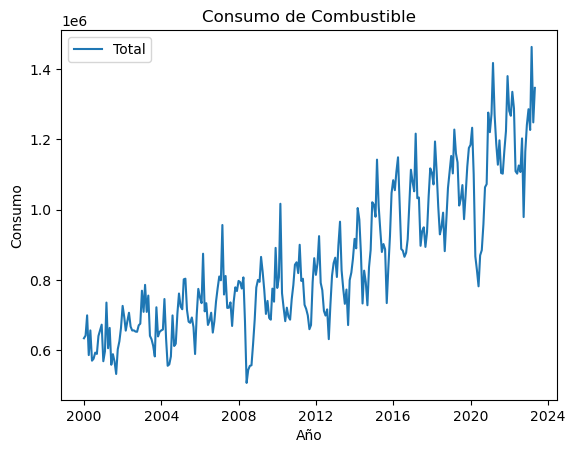

In [8]:

plt.plot(df_consumo_numerics["Fecha"], df_consumo_numerics['Diesel_conjunto'], label=column)
plt.gca().set(title='Consumo de Combustible', ylabel='Consumo', xlabel='Año')
plt.legend()
plt.show()

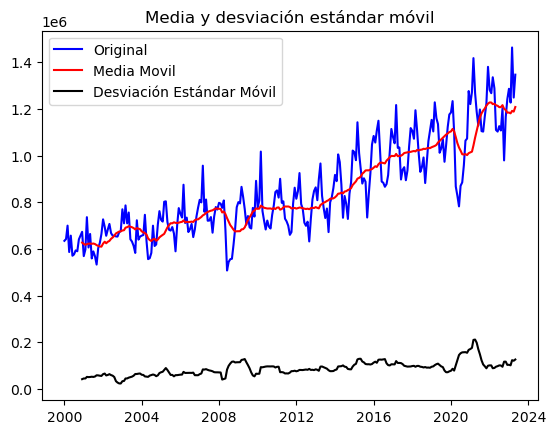

In [9]:
mediaMovil = df_consumo_numerics['Diesel_conjunto'].rolling(window=12).mean()
deMovil = df_consumo_numerics['Diesel_conjunto'].rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot( df_consumo_numerics['Fecha'], df_consumo_numerics['Diesel_conjunto'], color="blue", label="Original")
media = plt.plot(df_consumo_numerics['Fecha'], mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(df_consumo_numerics['Fecha'], deMovil, color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

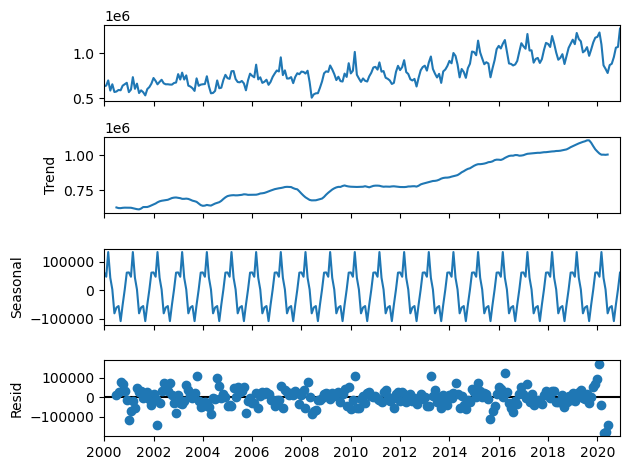

In [10]:
descomposicion = seasonal_decompose(df_consumo_train)
descomposicion.plot()
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller

# Calculate the result
result = adfuller(df_consumo_train['Diesel_conjunto'])

# Print the result
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -0.8083576884485949
p-value: 0.816654723721319


In [12]:
diff = df_consumo_train['Diesel_conjunto'].diff()
diff.dropna(inplace=True)

result = adfuller(diff)

# Print the result
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -6.575061240858303
p-value: 7.76266799771715e-09


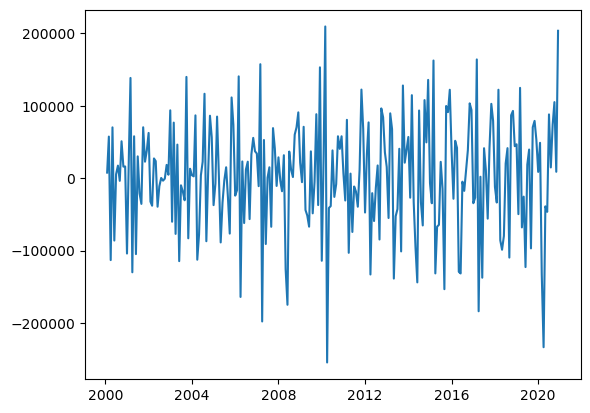

In [13]:
plt.plot(diff)
plt.show()


In [171]:
df_train_diff = df_consumo_train.diff()
df_train_diff.dropna(inplace=True)
scaler = StandardScaler()
consumo_diff = scaler.fit_transform(df_train_diff)
consumo_diff


array([[ 6.65654383e-02],
       [ 7.08208890e-01],
       [-1.49152208e+00],
       [ 8.72354800e-01],
       [-1.14335754e+00],
       [ 3.82029154e-02],
       [ 1.90745213e-01],
       [-7.97861661e-02],
       [ 6.24847627e-01],
       [ 1.73168389e-01],
       [ 1.76046899e-01],
       [-1.37471669e+00],
       [ 3.33835487e-01],
       [ 1.75250502e+00],
       [-1.70868216e+00],
       [ 7.13351151e-01],
       [-1.38499270e+00],
       [ 3.55760020e-01],
       [-3.02831170e-01],
       [-4.90390173e-01],
       [ 8.73885178e-01],
       [ 2.61091358e-01],
       [ 4.57909554e-01],
       [ 7.73464273e-01],
       [-4.50247470e-01],
       [-5.23012637e-01],
       [ 3.18938793e-01],
       [ 2.70568937e-01],
       [-5.40814817e-01],
       [-1.75733133e-01],
       [-2.86293108e-02],
       [-7.73308756e-02],
       [-4.08840798e-02],
       [ 2.03823962e-01],
       [ 2.88451131e-02],
       [ 1.17575388e+00],
       [-8.08181926e-01],
       [ 9.56981720e-01],
       [-1.0

In [209]:
entrenamiento = round(0.8*(len(consumo_diff)-1))
val_prueba = round(0.2*len(consumo_diff)-1)
validation = consumo_diff[(entrenamiento):entrenamiento+val_prueba+1]
train = consumo_diff[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))

len(validation)

50

In [210]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)



In [211]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))

len(x_val)

49

In [212]:
modelo1 = Sequential()
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada
modelo1.add(LSTM(lote, batch_input_shape=(lote,paso,caracteristicas),stateful=True))
modelo1.add(Dense(1))
modelo1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (1, 1)                    12        
                                                                 
 dense_3 (Dense)             (1, 1)                    2         
                                                                 
Total params: 14 (56.00 Byte)
Trainable params: 14 (56.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [213]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [214]:
epochs = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epochs,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50


200/200 [==============================] - 2s 3ms/step - loss: 1.0090 - val_loss: 1.3278
Epoch 2/50
200/200 [==============================] - 0s 1ms/step - loss: 0.9951 - val_loss: 1.3103
Epoch 3/50
200/200 [==============================] - 0s 1ms/step - loss: 0.9831 - val_loss: 1.2965
Epoch 4/50
200/200 [==============================] - 0s 1ms/step - loss: 0.9730 - val_loss: 1.2854
Epoch 5/50
200/200 [==============================] - 0s 2ms/step - loss: 0.9644 - val_loss: 1.2762
Epoch 6/50
200/200 [==============================] - 0s 1ms/step - loss: 0.9571 - val_loss: 1.2687
Epoch 7/50
200/200 [==============================] - 0s 1ms/step - loss: 0.9509 - val_loss: 1.2624
Epoch 8/50
200/200 [==============================] - 0s 1ms/step - loss: 0.9456 - val_loss: 1.2571
Epoch 9/50
200/200 [==============================] - 0s 1ms/step - loss: 0.9412 - val_loss: 1.2528
Epoch 10/50
200/200 [==============================] - 0s 2ms/step - loss: 0.9374 - val_loss: 1.2491
Epoch 11/5

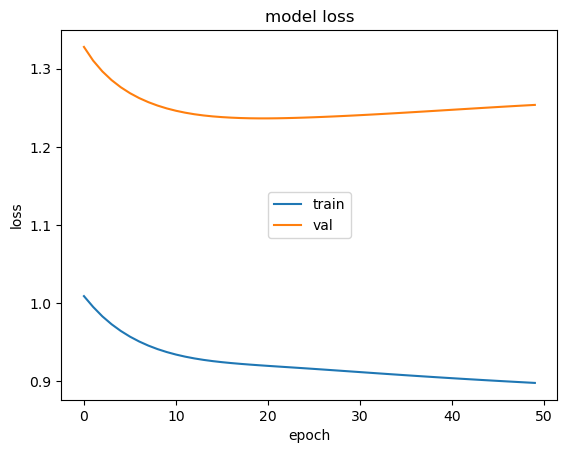

In [215]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [216]:
df_test_consumo = consumo_numerics.reset_index()
df_test_consumo = df_test_consumo[df_test_consumo['Fecha'] > '2020-12-31']
df_test_consumo = pd.concat([df_test_consumo['Fecha'], df_test_consumo['Diesel_conjunto']], axis=1, join="inner") 
df_test_consumo.set_index('Fecha', inplace=True)

df_test_diff = df_test_consumo.diff()
df_test_diff.dropna(inplace=True)
consumo_diff_test = scaler.fit_transform(df_test_diff)
len(consumo_diff_test)

28

In [217]:
x_test,y_test = supervisada(consumo_diff_test)
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_test)

27

In [224]:
prediccion_val = []
df_consumo = pd.concat([df_consumo_numerics['Fecha'], df_consumo_numerics['Diesel_conjunto']], axis=1, join="inner") 
df_consumo = df_consumo.dropna()
df_consumo.set_index('Fecha', inplace=True)
                                 
def prediccion_fun(data, modelo, batch_size, scaler, dif=False, dif_cant=1, Series=None, n=1):
    prediccion = [0] * (len(data))
    series_length = len(Series)
    i = 0
    for X in data:
        X = np.reshape(X, (1, 1, 1))
        yhat = modelo.predict(X, batch_size=batch_size, verbose=0)
        yhat = scaler.inverse_transform(yhat)
        if dif:
            # Calculate index and make sure it's within bounds
            index = min(n + dif_cant * i, series_length - 1)
            yhat = yhat + Series[index]
        prediccion[i] = yhat[0][0]
        i = i + 1
    return prediccion

prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = df_consumo.values , n=entrenamiento)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = df_consumo.values , n=((len(df_consumo)- len(x_test))))


In [225]:
df_val = pd.DataFrame(prediccion_val,index=df_consumo[(entrenamiento):(entrenamiento+val_prueba)].index)
df_test = pd.DataFrame(prediccion_test,index=df_consumo[(len(df_consumo)- len(x_test)):len(df_consumo)].index)



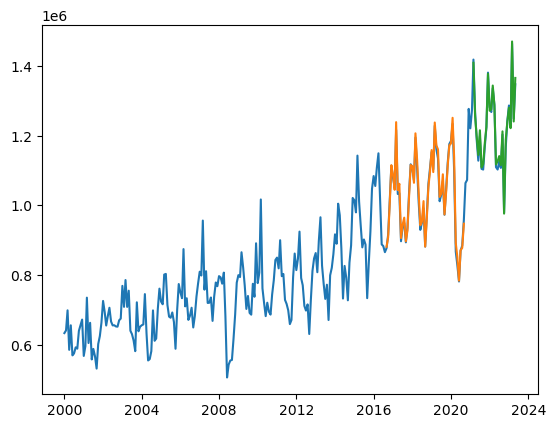

In [226]:
plt.plot(df_consumo)
plt.plot(df_val)
plt.plot(df_test)


### Modelo 2

In [230]:
modelo2 = Sequential()

modelo2.add(LSTM(50, batch_input_shape=(lote, paso, caracteristicas), stateful=True, return_sequences=True))
modelo2.add(Dropout(0.2))
modelo2.add(LSTM(50, return_sequences=True, stateful=True))
modelo2.add(Dropout(0.2))
modelo2.add(LSTM(50, stateful=True))
modelo2.add(Dropout(0.2))

modelo2.add(Dense(1))
modelo2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (1, 1, 50)                10400     
                                                                 
 dropout_3 (Dropout)         (1, 1, 50)                0         
                                                                 
 lstm_8 (LSTM)               (1, 1, 50)                20200     
                                                                 
 dropout_4 (Dropout)         (1, 1, 50)                0         
                                                                 
 lstm_9 (LSTM)               (1, 50)                   20200     
                                                                 
 dropout_5 (Dropout)         (1, 50)                   0         
                                                                 
 dense_5 (Dense)             (1, 1)                   

In [231]:

modelo2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])


In [232]:
epochs = 50
history= modelo2.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epochs,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
200/200 [==============================] - 6s 8ms/step - loss: 0.8212 - accuracy: 0.0000e+00 - val_loss: 2.1766 - val_accuracy: 0.0000e+00
Epoch 2/50
200/200 [==============================] - 1s 3ms/step - loss: 0.9630 - accuracy: 0.0000e+00 - val_loss: 1.1467 - val_accuracy: 0.0000e+00
Epoch 3/50
200/200 [==============================] - 1s 3ms/step - loss: 0.8333 - accuracy: 0.0000e+00 - val_loss: 1.2357 - val_accuracy: 0.0000e+00
Epoch 4/50
200/200 [==============================] - 1s 3ms/step - loss: 0.7999 - accuracy: 0.0000e+00 - val_loss: 1.1633 - val_accuracy: 0.0000e+00
Epoch 5/50
200/200 [==============================] - 1s 3ms/step - loss: 0.7992 - accuracy: 0.0000e+00 - val_loss: 1.1384 - val_accuracy: 0.0000e+00
Epoch 6/50
200/200 [==============================] - 1s 3ms/step - loss: 0.7800 - accuracy: 0.0000e+00 - val_loss: 1.2010 - val_accuracy: 0.0000e+00
Epoch 7/50
200/200 [==============================] - 1s 4ms/step - loss: 0.7851 - accuracy: 0.0000e

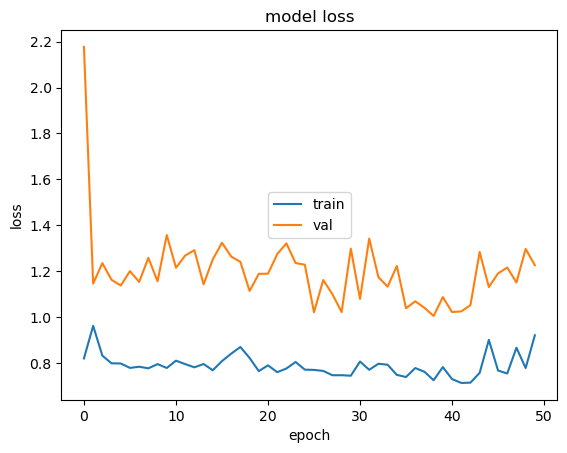

In [233]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [234]:

prediccion_val = prediccion_fun(x_val,modelo2, 1,scaler,dif=True,dif_cant=1, Series = df_consumo.values , n=entrenamiento)
prediccion_test = prediccion_fun(x_test,modelo2, 1,scaler,dif=True,dif_cant=1, Series = df_consumo.values , n=((len(df_consumo)- len(x_test))))

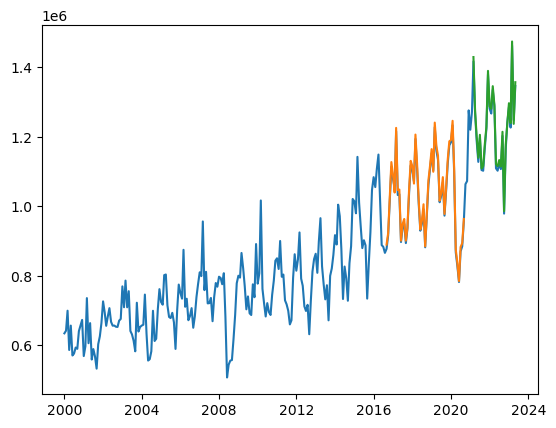

In [237]:
df_val2 = pd.DataFrame(prediccion_val,index=df_consumo[(entrenamiento):(entrenamiento+val_prueba)].index)
df_test2 = pd.DataFrame(prediccion_test,index=df_consumo[(len(df_consumo)- len(x_test)):len(df_consumo)].index)

plt.plot(df_consumo)
plt.plot(df_val2)
plt.plot(df_test2)
